In [1]:
pip install scikit-learn==1.3.2

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install catboost

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB 1.3 MB/s eta 0:01:20
   ---------------------------------------- 0.2/101.7 MB 2.5 MB/s eta 0:00:41
   ---------------------------------------- 0.5/101.7 MB 4.2 MB/s eta 0:00:25
   ---------------------------------------- 1.0/101.7 MB 5.6 MB/s eta 0:00:19
   ---------------------------------------- 1.0/101.7 MB 5.6 MB/s eta 0:00:19
    --------------------------------------- 2.2/101.7 MB 8.0 MB/s eta 0:00:13
   - -------------------------------------- 2.7/101.7 MB 8.6 MB/s eta 0:00:12
   - -------------------------------------- 3.3/101.7 MB 9.1 MB/s eta 0:00:11
   - -------------------------------------- 3.8/101.7 MB 9.3 MB/s eta 0:00:11
   - -------------------------------------- 4.4/101.7 MB 9.6 MB/s eta 0:00:11
   - -------------------------------------- 4.9/101.7 MB 9.7 MB/s eta 0:00:11
   -- ------------------------------------- 5.4/101.7 MB 9.9 MB/s eta 0

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostClassifier

In [5]:
df = pd.read_csv('churn.csv')

print("Информация о столбцах:")
print(df.info())

print("\nПервые 5 строк датасета:")
print(df.head())

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7

In [6]:
# Удаление идентификатора клиента
df = df.drop(columns=['customerID'])

# Обработка TotalCharges: замена нечисловых значений на 0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# Разделение на признаки и целевую переменную
X = df.drop(columns=['Churn'])
y = df['Churn']

# Разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=1
)

# Подсчет типов признаков
numerical = ['tenure', 'MonthlyCharges', 'TotalCharges']
binary = ['SeniorCitizen', 'gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
categorical = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
               'Contract', 'PaymentMethod']

print("Категориальных признаков:", len(categorical))
print("Бинарных признаков:", len(binary))
print("Числовых признаков:", len(numerical))

Категориальных признаков: 10
Бинарных признаков: 6
Числовых признаков: 3


In [8]:
# Преобразование бинарных признаков с помощью OrdinalEncoder
# SeniorCitizen уже в числовом формате (0/1), поэтому его не трогаем
binary_features_to_encode = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
ordinal_encoder = OrdinalEncoder()
X_train[binary_features_to_encode] = ordinal_encoder.fit_transform(X_train[binary_features_to_encode])
X_test[binary_features_to_encode] = ordinal_encoder.transform(X_test[binary_features_to_encode])

# Преобразование категориальных признаков с помощью OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)
X_train_encoded = onehot_encoder.fit_transform(X_train[categorical])
X_test_encoded = onehot_encoder.transform(X_test[categorical])

# Получение новых имен столбцов после OneHotEncoder
encoded_columns = onehot_encoder.get_feature_names_out(categorical)

# Преобразование закодированных данных в DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

# Удаление исходных категориальных столбцов
X_train = X_train.drop(columns=categorical)
X_test = X_test.drop(columns=categorical)

# Объединение с закодированными столбцами
X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)

# Вывод размерностей тренировочной и тестовой выборок
print("У тренировочной:", X_train.shape[0], ",", X_train.shape[1])
print("У тестовой:", X_test.shape[0], ",", X_test.shape[1])

У тренировочной: 5634 , 40
У тестовой: 1409 , 40


In [10]:
# Обучение случайного леса
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_train, y_train)
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Вычисление F1-метрики для случайного леса
f1_train_rf = f1_score(y_train, y_train_pred_rf, average='macro')
f1_test_rf = f1_score(y_test, y_test_pred_rf, average='macro')

print("F1 (macro) на тренировочной выборке (Random Forest):", f1_train_rf)
print("F1 (macro) на тестовой выборке (Random Forest):", f1_test_rf)

F1 (macro) на тренировочной выборке (Random Forest): 0.9970389742258317
F1 (macro) на тестовой выборке (Random Forest): 0.6998918216009282


In [11]:
# Обучение градиентного бустинга
gb_model = GradientBoostingClassifier(random_state=1)
gb_model.fit(X_train, y_train)
y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

# Вычисление F1-метрики для градиентного бустинга
f1_train_gb = f1_score(y_train, y_train_pred_gb, average='macro')
f1_test_gb = f1_score(y_test, y_test_pred_gb, average='macro')

print("F1 (macro) на тренировочной выборке (Gradient Boosting):", f1_train_gb)
print("F1 (macro) на тестовой выборке (Gradient Boosting):", f1_test_gb)

F1 (macro) на тренировочной выборке (Gradient Boosting): 0.7591926876370532
F1 (macro) на тестовой выборке (Gradient Boosting): 0.731624895187664


In [12]:
# Сравнение метрик
f1_difference = f1_test_gb - f1_test_rf
f1_difference_rounded = round(f1_difference, 2)

print("Разница F1 (macro) на тестовой выборке (Gradient Boosting - Random Forest):", f1_difference_rounded)

Разница F1 (macro) на тестовой выборке (Gradient Boosting - Random Forest): 0.03


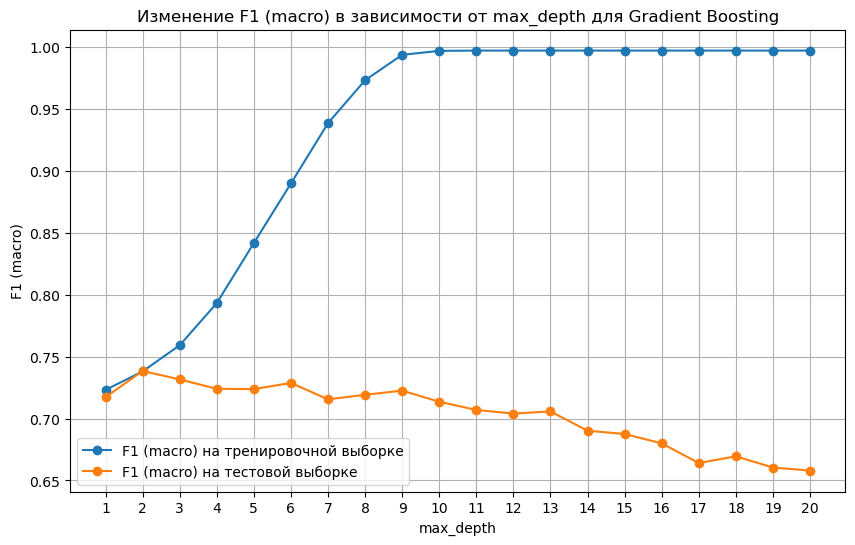

max_depth=1: F1 (train) = 0.723, F1 (test) = 0.717
max_depth=2: F1 (train) = 0.738, F1 (test) = 0.738
max_depth=3: F1 (train) = 0.759, F1 (test) = 0.732
max_depth=4: F1 (train) = 0.793, F1 (test) = 0.724
max_depth=5: F1 (train) = 0.842, F1 (test) = 0.724
max_depth=6: F1 (train) = 0.890, F1 (test) = 0.729
max_depth=7: F1 (train) = 0.939, F1 (test) = 0.716
max_depth=8: F1 (train) = 0.973, F1 (test) = 0.719
max_depth=9: F1 (train) = 0.994, F1 (test) = 0.723
max_depth=10: F1 (train) = 0.997, F1 (test) = 0.714
max_depth=11: F1 (train) = 0.997, F1 (test) = 0.707
max_depth=12: F1 (train) = 0.997, F1 (test) = 0.704
max_depth=13: F1 (train) = 0.997, F1 (test) = 0.706
max_depth=14: F1 (train) = 0.997, F1 (test) = 0.690
max_depth=15: F1 (train) = 0.997, F1 (test) = 0.688
max_depth=16: F1 (train) = 0.997, F1 (test) = 0.680
max_depth=17: F1 (train) = 0.997, F1 (test) = 0.664
max_depth=18: F1 (train) = 0.997, F1 (test) = 0.670
max_depth=19: F1 (train) = 0.997, F1 (test) = 0.660
max_depth=20: F1 (tra

In [14]:
# Списки для хранения метрик
max_depth_values = range(1, 21)  # Глубина от 1 до 20
f1_train_scores = []
f1_test_scores = []

# Перебор значений max_depth
for depth in max_depth_values:
    # Инициализация и обучение модели
    gb_model = GradientBoostingClassifier(max_depth=depth, random_state=1)
    gb_model.fit(X_train, y_train)
    
    # Предсказания
    y_train_pred = gb_model.predict(X_train)
    y_test_pred = gb_model.predict(X_test)
    
    # Вычисление F1-метрики (macro)
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    f1_test = f1_score(y_test, y_test_pred, average='macro')
    
    # Сохранение результатов
    f1_train_scores.append(f1_train)
    f1_test_scores.append(f1_test)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, f1_train_scores, label='F1 (macro) на тренировочной выборке', marker='o')
plt.plot(max_depth_values, f1_test_scores, label='F1 (macro) на тестовой выборке', marker='o')
plt.xlabel('max_depth')
plt.ylabel('F1 (macro)')
plt.title('Изменение F1 (macro) в зависимости от max_depth для Gradient Boosting')
plt.legend()
plt.grid(True)
plt.xticks(max_depth_values)
plt.show()

# Вывод значений для анализа
for depth, train_score, test_score in zip(max_depth_values, f1_train_scores, f1_test_scores):
    print(f"max_depth={depth}: F1 (train) = {train_score:.3f}, F1 (test) = {test_score:.3f}")

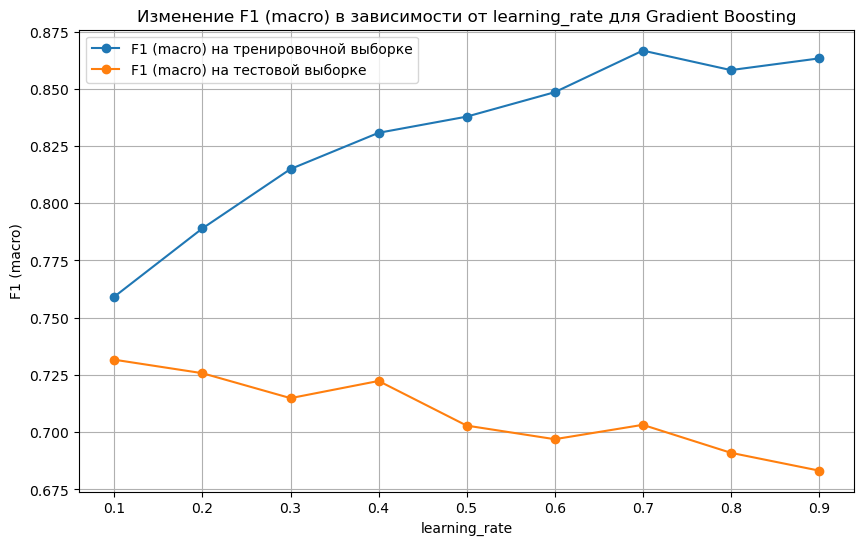

learning_rate=0.1: F1 (train) = 0.759, F1 (test) = 0.732
learning_rate=0.2: F1 (train) = 0.789, F1 (test) = 0.726
learning_rate=0.3: F1 (train) = 0.815, F1 (test) = 0.715
learning_rate=0.4: F1 (train) = 0.831, F1 (test) = 0.722
learning_rate=0.5: F1 (train) = 0.838, F1 (test) = 0.703
learning_rate=0.6: F1 (train) = 0.849, F1 (test) = 0.697
learning_rate=0.7: F1 (train) = 0.867, F1 (test) = 0.703
learning_rate=0.8: F1 (train) = 0.858, F1 (test) = 0.691
learning_rate=0.9: F1 (train) = 0.863, F1 (test) = 0.683


In [15]:
# Списки для хранения метрик
learning_rates = np.arange(0.1, 1.0, 0.1)  # Скорость обучения от 0.1 до 0.9 с шагом 0.1
f1_train_scores = []
f1_test_scores = []

# Перебор значений learning_rate
for lr in learning_rates:
    # Инициализация и обучение модели
    gb_model = GradientBoostingClassifier(learning_rate=lr, random_state=1)
    gb_model.fit(X_train, y_train)
    
    # Предсказания
    y_train_pred = gb_model.predict(X_train)
    y_test_pred = gb_model.predict(X_test)
    
    # Вычисление F1-метрики (macro)
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    f1_test = f1_score(y_test, y_test_pred, average='macro')
    
    # Сохранение результатов
    f1_train_scores.append(f1_train)
    f1_test_scores.append(f1_test)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, f1_train_scores, label='F1 (macro) на тренировочной выборке', marker='o')
plt.plot(learning_rates, f1_test_scores, label='F1 (macro) на тестовой выборке', marker='o')
plt.xlabel('learning_rate')
plt.ylabel('F1 (macro)')
plt.title('Изменение F1 (macro) в зависимости от learning_rate для Gradient Boosting')
plt.legend()
plt.grid(True)
plt.xticks(learning_rates)
plt.show()

# Вывод значений для анализа
for lr, train_score, test_score in zip(learning_rates, f1_train_scores, f1_test_scores):
    print(f"learning_rate={lr:.1f}: F1 (train) = {train_score:.3f}, F1 (test) = {test_score:.3f}")

In [22]:
print("Информация о столбцах:")
print(X_train.info())

print("\nПервые 5 строк датасета:")
print(X_train.head())

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 2246 to 1309
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   5634 non-null   float64
 1   SeniorCitizen                            5634 non-null   int64  
 2   Partner                                  5634 non-null   float64
 3   Dependents                               5634 non-null   float64
 4   tenure                                   5634 non-null   int64  
 5   PhoneService                             5634 non-null   float64
 6   PaperlessBilling                         5634 non-null   float64
 7   MonthlyCharges                           5634 non-null   float64
 8   TotalCharges                             5634 non-null   float64
 9   MultipleLines_No                         5634 non-null   float64
 10  MultipleLines_No phone serv

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

# Чтение датасета
df = pd.read_csv('churn.csv')

# Удаление идентификатора клиента
df = df.drop(columns=['customerID'])

# Обработка TotalCharges: замена нечисловых значений на 0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# Разделение на признаки и целевую переменную
X = df.drop(columns=['Churn'])
y = df['Churn']

# Разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=1
)

# Список категориальных и бинарных признаков
cat_features = ['SeniorCitizen', 'gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                'Contract', 'PaymentMethod']

# Инициализация CatBoostClassifier
catboost_model = CatBoostClassifier(
    random_state=1,
    n_estimators=100,
    cat_features=cat_features,
    verbose=0  # Отключаем вывод логов
)

# Обучение модели
catboost_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_test_pred = catboost_model.predict(X_test)

# Вычисление F1-метрики (macro)
f1_test = f1_score(y_test, y_test_pred, average='macro')

# Округление до третьего знака после точки
f1_test_rounded = round(f1_test, 3)

print("F1 (macro) на тестовой выборке (CatBoost):", f1_test_rounded)

F1 (macro) на тестовой выборке (CatBoost): 0.732


In [25]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class GradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.base_pred = None

    def fit(self, X, y):
        # Преобразуем y в числовой формат: "No" → 0, "Yes" → 1
        y = np.where(y == "Yes", 1, 0)
        
        # Инициализация предсказаний как среднее значение целевой переменной
        self.base_pred = np.mean(y)
        y_hat = np.full_like(y, self.base_pred, dtype=np.float64)
        residuals = y - y_hat

        for i in range(self.n_estimators):
            # Обучение дерева на остатках
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=i)
            tree.fit(X, residuals)
            self.trees.append(tree)

            # Получаем предсказание текущей моделью
            predictions = tree.predict(X)

            # Добавляем предсказание текущей модели в весь бустинг
            y_hat += self.learning_rate * predictions
            residuals = y - y_hat

    def predict(self, X):
        # Начальные предсказания
        y_hat = np.full(X.shape[0], self.base_pred, dtype=np.float64)
        
        # Добавляем предсказания каждого дерева
        for tree in self.trees:
            y_hat += self.learning_rate * tree.predict(X)
        
        # Бинарная классификация: порог 0.5
        return np.where(y_hat > 0.5, 1, 0)

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeRegressor

# Реализация класса GradientBoosting
class GradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.base_pred = None

    def fit(self, X, y):
        # Преобразуем y в числовой формат: "No" → 0, "Yes" → 1
        y = np.where(y == "Yes", 1, 0)
        
        # Инициализация предсказаний как среднее значение целевой переменной
        self.base_pred = np.mean(y)
        y_hat = np.full_like(y, self.base_pred, dtype=np.float64)
        residuals = y - y_hat

        for i in range(self.n_estimators):
            # Обучение дерева на остатках
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=i)
            tree.fit(X, residuals)
            self.trees.append(tree)

            # Получаем предсказание текущей моделью
            predictions = tree.predict(X)

            # Добавляем предсказание текущей модели в весь бустинг
            y_hat += self.learning_rate * predictions
            residuals = y - y_hat

    def predict(self, X):
        # Начальные предсказания
        y_hat = np.full(X.shape[0], self.base_pred, dtype=np.float64)
        
        # Добавляем предсказания каждого дерева
        for tree in self.trees:
            y_hat += self.learning_rate * tree.predict(X)
        
        # Бинарная классификация: порог 0.5
        return np.where(y_hat > 0.5, 1, 0)

# Чтение датасета
df = pd.read_csv('churn.csv')

# Удаление идентификатора клиента
df = df.drop(columns=['customerID'])

# Обработка TotalCharges: замена нечисловых значений на 0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# Разделение на признаки и целевую переменную
X = df.drop(columns=['Churn'])
y = df['Churn']

# Разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=1
)

# Подсчет типов признаков
numerical = ['tenure', 'MonthlyCharges', 'TotalCharges']
binary = ['SeniorCitizen', 'gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
categorical = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
               'Contract', 'PaymentMethod']

# Преобразование бинарных признаков с помощью OrdinalEncoder
binary_features_to_encode = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
ordinal_encoder = OrdinalEncoder()
X_train[binary_features_to_encode] = ordinal_encoder.fit_transform(X_train[binary_features_to_encode])
X_test[binary_features_to_encode] = ordinal_encoder.transform(X_test[binary_features_to_encode])

# Преобразование категориальных признаков с помощью OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)
X_train_encoded = onehot_encoder.fit_transform(X_train[categorical])
X_test_encoded = onehot_encoder.transform(X_test[categorical])

# Получение новых имен столбцов после OneHotEncoder
encoded_columns = onehot_encoder.get_feature_names_out(categorical)

# Преобразование закодированных данных в DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

# Удаление исходных категориальных столбцов
X_train = X_train.drop(columns=categorical)
X_test = X_test.drop(columns=categorical)

# Объединение с закодированными столбцами
X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)

# Инициализация и обучение модели
gb_model = GradientBoosting(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_test_pred = gb_model.predict(X_test)

# Преобразуем y_test в числовой формат: "No" → 0, "Yes" → 1
y_test_numeric = np.where(y_test == "Yes", 1, 0)

# Вычисление F1-метрики (macro)
f1_test = f1_score(y_test_numeric, y_test_pred, average='macro')

# Округление до третьего знака после точки
f1_test_rounded = round(f1_test, 3)

print("F1 (macro) на тестовой выборке (GradientBoosting):", f1_test_rounded)

F1 (macro) на тестовой выборке (GradientBoosting): 0.716
